<a href="https://colab.research.google.com/github/MUbarak123-56/fast-ai/blob/master/chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -Uqq fastbook

In [4]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [5]:
path = untar_data(URLs.IMAGENETTE)

In [6]:
dblock = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()),
    get_items = get_image_files,
    get_y = parent_label,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size = 224, min_scale = 0.75)
)

In [7]:
dls = dblock.dataloaders(path, bs = 64)

In [8]:
model = xresnet50(n_out=dls.c)

In [9]:
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.617656,2.320189,0.350635,00:36
1,1.213305,1.587587,0.562733,00:32
2,0.959987,1.004605,0.702390,00:32
3,0.726449,0.684363,0.775579,00:32
4,0.595311,0.534527,0.830097,00:32


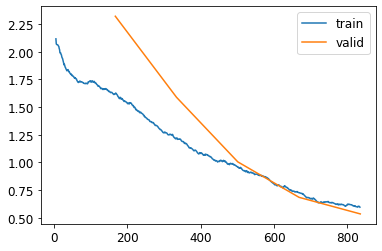

In [10]:
learn.recorder.plot_loss()

## Normalization

In [11]:
x, y = dls.one_batch()

In [12]:
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.4663, 0.4499, 0.4040], device='cuda:0'),
 TensorImage([0.2807, 0.2737, 0.2953], device='cuda:0'))

In [15]:
def get_dls(bs, size):
  dblock = DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_items = get_image_files,
      get_y = parent_label,
      item_tfms = Resize(460),
      batch_tfms = [*aug_transforms(size = size,min_scale = 0.75), 
                    Normalize.from_stats(*imagenet_stats)]
  )
  return dblock.dataloaders(path, bs = bs)

In [17]:
dls = get_dls(64, 224)

In [18]:
x, y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.1468, -0.0489,  0.0312], device='cuda:0'),
 TensorImage([1.1314, 1.1599, 1.2662], device='cuda:0'))

In [19]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.703971,3.023288,0.377521,00:33
1,1.267656,1.909727,0.510456,00:33
2,0.962123,1.008217,0.698282,00:32


epoch,train_loss,valid_loss,accuracy,time
0,1.703971,3.023288,0.377521,00:33
1,1.267656,1.909727,0.510456,00:33
2,0.962123,1.008217,0.698282,00:32
3,0.761418,0.695675,0.785661,00:32
4,0.611162,0.588474,0.820015,00:33


## Progressive Resizing

In [20]:
dls = get_dls(128,128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func = CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.615366,1.836136,0.471247,00:29
1,1.270414,1.414123,0.609410,00:28
2,0.983855,0.892708,0.727782,00:28
3,0.754334,0.656234,0.794249,00:28


In [21]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.825982,0.996665,0.696042,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.673801,0.630648,0.800597,00:33
1,0.656349,0.689646,0.776326,00:33
2,0.595840,0.576146,0.818148,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.673801,0.630648,0.800597,00:33
1,0.656349,0.689646,0.776326,00:33
2,0.595840,0.576146,0.818148,00:33
3,0.480071,0.483809,0.848768,00:33
4,0.436425,0.461505,0.853996,00:32


### Test time Augmentation

In [22]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.8569828271865845

## MixUp

In [23]:
model = xresnet50(n_out = dls.c)
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy, cbs = MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.926765,2.062747,0.419716,00:28
1,1.677529,1.615202,0.542196,00:28
2,1.467388,1.317404,0.572069,00:28
3,1.306639,0.775232,0.757655,00:28
4,1.185897,0.663792,0.802838,00:28


### Label Smoothing

In [24]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.727952,1.869134,0.505975,00:28
1,1.538560,1.908096,0.465646,00:28
2,1.299433,1.365633,0.661688,00:28
3,1.142084,1.042117,0.790889,00:28
4,1.030161,0.988805,0.815907,00:28
